<h1 align='center'><b><font color='indianred'></p>Spam Detection</b></h1>

<font color = 'indianred' size = 10 > </font>


In [1]:
# Importing the zipfile module for working with zip files
import zipfile

# Importing the tarfile module for working with tar files
import tarfile
# Importing all neccessary modeules
import spacy
import pandas as pd
from pathlib import Path
import sys
import re
import joblib

In [2]:
# Mount google drive if google colab is being used
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set base folder and append custome module paths
if 'google.colab' in str(get_ipython()):
  !pip install -U nltk -qq
  !pip install -U spacy==3.6.0 -qq
  !python -m spacy download en_core_web_sm -qq
  base_folder = Path('/content/drive/Othercomputers/Samsung_Laptop/PROGRAMMING/Python/Datasets')
  sys.path.append('/content/drive/Othercomputers/Samsung_Laptop/PROGRAMMING/Python/Custom_Functions_py_files')
else:
    base_folder = Path('/Users/12544/Desktop/PROGRAMMING/Python/Datasets')
    sys.path.append('/Users/12544/Desktop/PROGRAMMING/Python/Custom_Functions_py_files')

2023-08-11 02:18:48.618093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 24.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
data_folder = base_folder/'datasets'
archive_folder = base_folder/'archive'
model_folder = base_folder/'models'

In [5]:
# Check for the downloaded Zip file containig the data is csv format
for entries in archive_folder.iterdir():
  if 'zip' in entries.name:
    print(entries.name)

trainingandtestdata.zip
COVID-19.zip
master.zip
dataverse_files.zip
archive.zip
COVID-19.zip.1


In [6]:
# Check the files in the zip folder
file = archive_folder/'archive.zip'
with zipfile.ZipFile(file, 'r') as f:
  namelist = f.namelist()
print(namelist)

['spam.csv']


In [7]:
# Extract the csv into the data folder
with zipfile.ZipFile(file, 'r') as f:
  f.extract('spam.csv', path = data_folder)

In [8]:
# Read csv file into a dataframe
df = pd.read_csv(data_folder/'spam.csv', encoding="ISO-8859-1")

In [9]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [10]:
# Renaming the main columns needed and dropping unused columns
df.rename(columns={'v1': 'label', 'v2': 'message'}, inplace = True)
df = df.drop(labels=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [11]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
df.shape

(5572, 2)

In [13]:
# Install and import the swifter module
!pip install swifter
import swifter

In [14]:
# Get the percentage of spam observations to the percentage of ham
perc_of_spam = sum(df['label'].swifter.apply(lambda x: 1 if x == "spam" else 0))/len(df) * 100

Pandas Apply:   0%|          | 0/5572 [00:00<?, ?it/s]

In [15]:
print("The percentage of spam in the dataset is", perc_of_spam, "While the percentage of ham is", 100 - perc_of_spam)

The percentage of spam in the dataset is 13.406317300789663 While the percentage of ham is 86.59368269921033


# <font color ='indianred'> **Using a smaller subset for the model**

In [16]:
# Import required nltk packages
import nltk
nltk.download('stopwords')  # Download the stopwords corpus
from nltk.corpus import stopwords as nltk_stopwords  # Stopwords corpus

# Import tweet tokenizer from nltk
from nltk.tokenize import TweetTokenizer

# Import CountVectorizer and TfidfVectorizer from scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Import the joblib library for saving and loading models
import joblib

# Import scikit-learn classes for building models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix

In [18]:
import custom_preprocessor_mod as cp
from  featurizer import ManualFeatures
from  plot_learning_curve import plot_learning_curve

In [19]:
# Change the label column into ones and zeroes (1 for spam email and 0 for non-spam)
df['label'] = df['label'].swifter.apply(lambda x: 1 if x=="spam" else 0)

Pandas Apply:   0%|          | 0/5572 [00:00<?, ?it/s]

In [20]:
len(df)

5572

In [21]:
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [22]:
# Splitting the dataset into train and test samples. 50% of the data for each
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.5, random_state=10)

# print shape of the datasets
print(f'Shape of Training data set is : {train_data.shape}')
print(f'Shape of Test data set is : {test_data.shape}')

Shape of Training data set is : (2786, 2)
Shape of Test data set is : (2786, 2)


In [23]:
# Take a small subsect(10%) of the data set for model building
train_small = train_data.sample(frac=0.5, replace=True, random_state=1)
test_small = test_data.sample(frac=0.7, replace=True, random_state=1)

In [24]:
len(train_small)

1393

In [25]:
# Check the proportion of train and test samples
train_small['label'].value_counts()

0    1198
1     195
Name: label, dtype: int64

# <font color ='indian red'> **Pipeline1: Data Processing + Sparse Embeddings (TF-IDF) + ML Model**

In [26]:
# Create a numpy array of the x and y training and test data
X_train = train_small['message'].values
X_test = test_small['message'].values
y_train = train_small['label'].values
y_test = test_small['label'].values

print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_test: {X_test.shape} y_test: {y_test.shape}')

X_train: (1393,) y_train: (1393,)
X_test: (1950,) y_test: (1950,)


In [27]:
X_train[0]

"Lemme know when I can swing by and pick up, I'm free basically any time after 1 all this semester"

In [28]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
# Using the custom preprocessor that was imported earlier, clean the text data
X_train_cleaned = cp.SpacyPreprocessor(model = "en_core_web_sm").transform(X_train)
X_test_cleaned = cp.SpacyPreprocessor(model = "en_core_web_sm").transform(X_test)

/content/drive/Othercomputers/Samsung_Laptop/PROGRAMMING/Python/Custom_Functions_py_files/custom_preprocessor_mod.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


## <font color ='indian red'>*Create Pipeline*

In [30]:
X_train_cleaned[0]

'lemme know swing pick free basically time 1 semester'

In [31]:
# Create a pipeline which contains the TfidfVectorizer and LogisticRegression
classifier_1 = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
    ('classifier', LogisticRegression(max_iter=1000))
])

## <font color ='indian red'>*Parameter Grid*

In [32]:
# Create the grid search parameter
param_grid_classifier_1 = {'vectorizer__max_features': [100, 500, 1000, 2000, 5000],
                            'classifier__C': [0.1, 1, 10, 100, 100000]
                           }

## <font color ='indian red'>*Specify GridSearch and fit the model*

In [33]:
# We will use the Gridsearth to fine tune hyperparameters using cross validation using the scoring method of recall
grid_classifier_1 = GridSearchCV(estimator=classifier_1, param_grid=param_grid_classifier_1, scoring='recall',  cv = 6)

In [34]:
# Fit the model on training data
grid_classifier_1.fit(X_train_cleaned, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(token_pattern='[\\S]+')),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100, 100000],
                         'vectorizer__max_features': [100, 500, 1000, 2000,
                                                      5000]},
             scoring='recall')

## <font color ='indian red'>*Get Best Parameters*

In [35]:
# Get the best parameters based on the results
print(f'Best cross-validation score: {grid_classifier_1.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_1.best_params_)
print("\nBest estimator: ", grid_classifier_1.best_estimator_)

Best cross-validation score: 0.92

Best parameters:  {'classifier__C': 100000, 'vectorizer__max_features': 2000}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=2000, token_pattern='[\\S]+')),
                ('classifier', LogisticRegression(C=100000, max_iter=1000))])


## <font color ='indian red'>*Save the Model*

In [36]:
file_Project3_best_estimator_pipeline1_round1 = model_folder / 'Project3_pipeline1_best_estimator_round1'
file_Project3_complete_grid_pipeline1_round1 = model_folder / 'Project3_pipeline1_complete_grid_round1'

In [37]:
joblib.dump(grid_classifier_1.best_estimator_, file_Project3_best_estimator_pipeline1_round1)
joblib.dump(grid_classifier_1, file_Project3_complete_grid_pipeline1_round1)

['/content/drive/Othercomputers/Samsung_Laptop/PROGRAMMING/Python/Datasets/models/Project3_pipeline1_complete_grid_round1']

## <font color ='indian red'>*Load Saved Model*

In [38]:
# load the saved model
best_estimator_pipeline1_round1 = joblib.load(file_Project3_best_estimator_pipeline1_round1)
complete_grid_pipeline1_round1 = joblib.load(file_Project3_complete_grid_pipeline1_round1)

## <font color ='indian red'>*Plot Learning Curve*

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

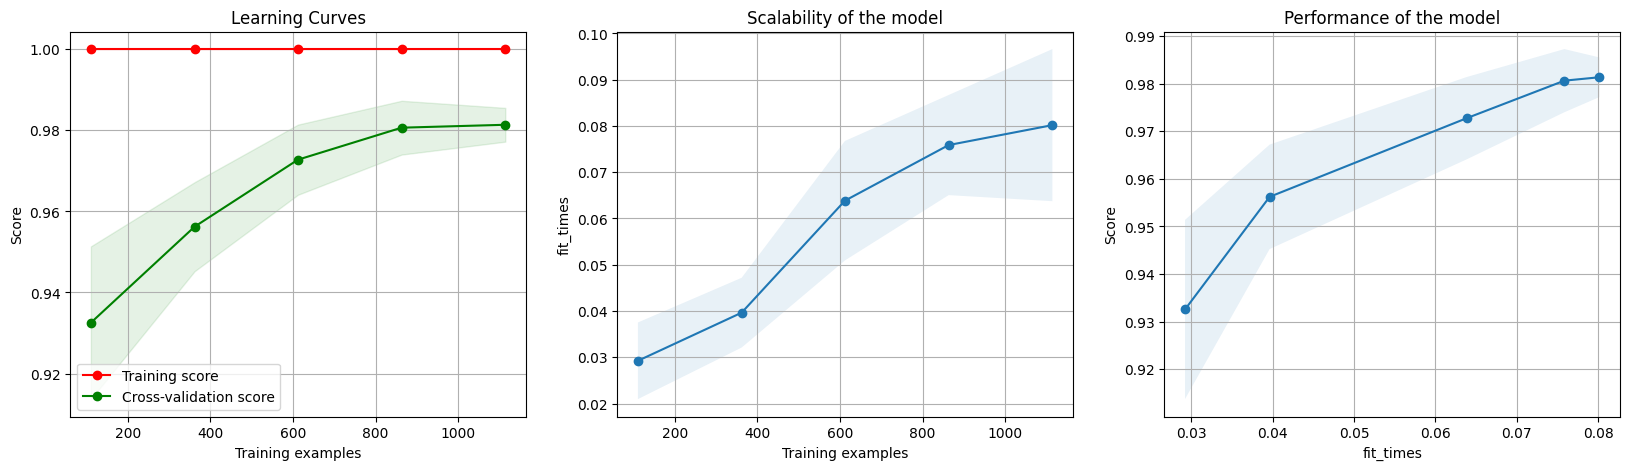

In [39]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline1_round1, 'Learning Curves',
                    X_train_cleaned, y_train, n_jobs=-1)

In [40]:
# let's check the train scores
print(best_estimator_pipeline1_round1.score(X_train_cleaned, y_train))

# let's check the cross validation score
print(complete_grid_pipeline1_round1.best_score_)

1.0
0.9228219696969697


In [41]:
# Final Pipeline
def final_pipeline(text):
    cleaned_text = X_test_cleaned
    predictions = best_estimator_pipeline1_round1.predict(cleaned_text)
    return predictions

In [42]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

In [43]:
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1684
           1       0.97      0.85      0.90       266

    accuracy                           0.98      1950
   macro avg       0.97      0.92      0.94      1950
weighted avg       0.98      0.98      0.97      1950



# <font color ='indian red'> **Pipeline 2: Data Preprocessing + Manual Features(Feature Engineering) + ML Model**

In [44]:
import re

In [45]:
# Create an instance of the ManualFeatures class
featurizer = ManualFeatures(spacy_model='en_core_web_sm')

In [46]:
# Transform the X_train data into manual features
X_train_features, feature_names = featurizer.fit_transform(X_train_cleaned)

/content/drive/Othercomputers/Samsung_Laptop/PROGRAMMING/Python/Custom_Functions_py_files/custom_preprocessor_mod.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [47]:
X_train_features

array([[ 8., 50., 43., ...,  0.,  1.,  1.],
       [17., 89., 73., ...,  0.,  2.,  0.],
       [ 7., 33., 27., ...,  0.,  2.,  1.],
       ...,
       [ 2.,  8.,  7., ...,  0.,  0.,  1.],
       [ 6., 38., 33., ...,  0.,  0.,  1.],
       [ 1.,  4.,  4., ...,  0.,  0.,  0.]])

In [48]:
# Convert the numpy array into a dataframe
df_feature_train = pd.DataFrame(X_train_features, columns = feature_names)

In [49]:
df_feature_train.head()

,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner
0,8.0,50.0,43.0,4.777778,1.0,1.0,2.0,5.0,0.0,1.0,1.0
1,17.0,89.0,73.0,4.055556,0.0,0.0,4.0,14.0,0.0,2.0,0.0
2,7.0,33.0,27.0,3.375000,0.0,0.0,0.0,2.0,0.0,2.0,1.0
3,4.0,20.0,17.0,3.400000,0.0,0.0,1.0,4.0,0.0,0.0,0.0
4,5.0,21.0,17.0,2.833333,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [50]:
len(df_feature_train)

1393

In [51]:
# Download pyspellchecker
! pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 10.1 MB/s eta 0:00:00


In [52]:
from spellchecker import SpellChecker

spell = SpellChecker()

def check_spelling(sentence):
  misspelled = spell.unknown(re.findall(r"[\w']+|[.,!?;]", sentence))
  return len(misspelled)

The coode above imports the SpellChecker class from the spellchecker module.

The function check_spelling takes in a sentence as input and returns the number or spelling mistakes in the sentence

In [53]:
# Convert the numpy array of text into a dataframe
X_train_text = pd.DataFrame(X_train_cleaned)

In [54]:
X_train_text.head()

,0
0,lemme know swing pick free basically time 1 se...
1,xmas story peace xmas msg love xmas miracle je...
2,aiyah ok wat long get improve wat
3,ugh fuck resubbe eve
4,eh u send wrongly lar


In [55]:
# Include an additional column in the train data that shows the number of mistakes in the sentence
df_feature_train['no_of_spelling_mistakes'] = X_train_text[0].swifter.apply(lambda x: check_spelling(x))

Pandas Apply:   0%|          | 0/1393 [00:00<?, ?it/s]

In [56]:
df_feature_train.head()

,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner,no_of_spelling_mistakes
0,8.0,50.0,43.0,4.777778,1.0,1.0,2.0,5.0,0.0,1.0,1.0,0
1,17.0,89.0,73.0,4.055556,0.0,0.0,4.0,14.0,0.0,2.0,0.0,1
2,7.0,33.0,27.0,3.375000,0.0,0.0,0.0,2.0,0.0,2.0,1.0,1
3,4.0,20.0,17.0,3.400000,0.0,0.0,1.0,4.0,0.0,0.0,0.0,1
4,5.0,21.0,17.0,2.833333,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0


Here, manual feaures are used for the ML model. The manual features include count of words, count of characters, average word length, count of digitd, count of verbs, number of spelling mistakes etc.

## <font color ='indian red'>*Create Pipeline*

In [57]:
# Create the pipeline which includes just the Logistic regression
classifier_2 = Pipeline([
    ('classifier', LogisticRegression(max_iter=10000)),
                        ])

## <font color ='indian red'>*Parameter Grid*

In [58]:
# Ideally we can specify range of values for other parameters
# If the search space is very large then we should use RandomSerachCV
# or some other methods

param_grid_classifier_2 = {'classifier__C': [0.01, 10, 1000, 100000]}

## <font color ='indian red'>*Specify GridSearch and Fit the model*

In [59]:
# the typical value of cv used is 5. We are using 3, just for demonstration.

grid_classifier_2 = GridSearchCV(estimator=classifier_2,
                                 param_grid=param_grid_classifier_2,
                                 cv=6)

In [60]:
# Fit the model on training data
grid_classifier_2.fit(df_feature_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.01, 10, 1000, 100000]})

## <font color ='indian red'>*Get Best Paramters*

In [61]:
print(f'Best cross-validation score: {grid_classifier_2.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_2.best_params_)
print("\nBest estimator: ", grid_classifier_2.best_estimator_)

Best cross-validation score: 0.98

Best parameters:  {'classifier__C': 10}

Best estimator:  Pipeline(steps=[('classifier', LogisticRegression(C=10, max_iter=10000))])


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

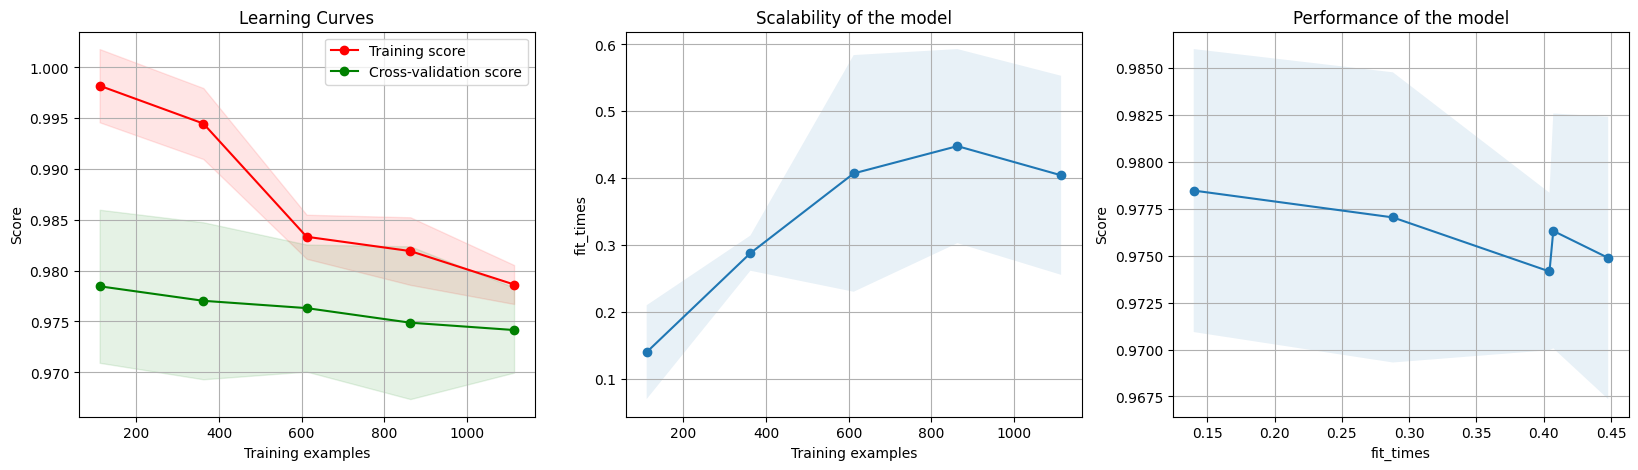

In [62]:
# plot learning curces
plot_learning_curve(grid_classifier_2.best_estimator_, 'Learning Curves',
                    df_feature_train, y_train, n_jobs=-1)

In [63]:
# let's check the train scores
print(grid_classifier_2.best_estimator_.score(df_feature_train, y_train))

# let's check the cross validation score
print(grid_classifier_2.best_score_)

0.9784637473079684
0.9755808790883528


## <font color ='indian red'>*Evaluate model on test dataset*

In [64]:
# Final Pipeline
def final_pipeline(text):
    X_test_features, feature_names = featurizer.fit_transform(text)
    df_feature_test = pd.DataFrame(X_test_features, columns = feature_names)
    X_test_text = pd.DataFrame(text)
    df_feature_test['no_of_spelling_mistakes'] = X_test_text.iloc[:, 0].swifter.apply(lambda x: check_spelling(x))
    predictions = grid_classifier_2.best_estimator_.predict(df_feature_test)
    return predictions

The function above does all the transformation and data processing for a new set of data(text) and uses the model to make predictions

In [65]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test_cleaned)

/content/drive/Othercomputers/Samsung_Laptop/PROGRAMMING/Python/Custom_Functions_py_files/custom_preprocessor_mod.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


Pandas Apply:   0%|          | 0/1950 [00:00<?, ?it/s]

In [66]:
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1684
           1       0.93      0.85      0.89       266

    accuracy                           0.97      1950
   macro avg       0.95      0.92      0.94      1950
weighted avg       0.97      0.97      0.97      1950



## <font color ='indian red'>**Pipeline 3: Data Preprocessing + Manual Features + Sparse Embeddings(TF-IDF) + ML Model**

In [67]:
# Combine text data and the manual features into one dataframe
X_train_combined = pd.concat((pd.DataFrame(X_train_cleaned, columns=['cleaned text']),
                              pd.DataFrame(df_feature_train)), axis = 1)

In [68]:
df_feature_train.head()

,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner,no_of_spelling_mistakes
0,8.0,50.0,43.0,4.777778,1.0,1.0,2.0,5.0,0.0,1.0,1.0,0
1,17.0,89.0,73.0,4.055556,0.0,0.0,4.0,14.0,0.0,2.0,0.0,1
2,7.0,33.0,27.0,3.375000,0.0,0.0,0.0,2.0,0.0,2.0,1.0,1
3,4.0,20.0,17.0,3.400000,0.0,0.0,1.0,4.0,0.0,0.0,0.0,1
4,5.0,21.0,17.0,2.833333,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0


In [69]:
len(X_train_combined)

1393

In [70]:
X_train_combined.head()

,cleaned text,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner,no_of_spelling_mistakes
0,lemme know swing pick free basically time 1 se...,8.0,50.0,43.0,4.777778,1.0,1.0,2.0,5.0,0.0,1.0,1.0,0
1,xmas story peace xmas msg love xmas miracle je...,17.0,89.0,73.0,4.055556,0.0,0.0,4.0,14.0,0.0,2.0,0.0,1
2,aiyah ok wat long get improve wat,7.0,33.0,27.0,3.375000,0.0,0.0,0.0,2.0,0.0,2.0,1.0,1
3,ugh fuck resubbe eve,4.0,20.0,17.0,3.400000,0.0,0.0,1.0,4.0,0.0,0.0,0.0,1
4,eh u send wrongly lar,5.0,21.0,17.0,2.833333,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0


In [71]:
subset = X_train_combined[0:10]
subset.shape

(10, 13)

In [72]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)

In [73]:
sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=500)), ])

In [74]:
sparse_features.fit_transform(subset.iloc[:, 1:])
vectorizer.fit_transform(subset.iloc[:, 0])

<10x88 sparse matrix of type '<class 'numpy.float64'>'
	with 90 stored elements in Compressed Sparse Row format>

In [75]:
combined_features = ColumnTransformer(
 transformers=[
     ('tfidf', vectorizer, 'cleaned text'),
      ], remainder=sparse_features
     )

In [76]:
test = combined_features.fit_transform(subset)

In [77]:
classifier_3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', LogisticRegression(max_iter=10000)),
                        ])

In [78]:
param_grid_classifier_3 = {'combined_features__tfidf__tfidf__max_features': [100, 500, 1000, 2000, 5000],
                           'classifier__C': [0.1, 1, 10, 100, 100000]
                          }

In [79]:
grid_classifier_3 = GridSearchCV(estimator=classifier_3,
                                 param_grid=param_grid_classifier_3,
                                 cv=6)
grid_classifier_3.fit(X_train_combined, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('combined_features',
                                        ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                     SparseTransformer())]),
                                                          transformers=[('tfidf',
                                                                         Pipeline(steps=[('tfidf',
                                                                                          TfidfVectorizer(max_features=500))]),
                                                                         'cleaned '
                                                                         'text')])),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100, 100000],
                         'combined_features__tfidf__tfidf__max_features': [100,
                                                                           500,
                                                                           1000,
                                                                           2000,
                                                                           5000]})

In [80]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_3.best_score_))
print("\nBest parameters: ", grid_classifier_3.best_params_)
print("\nBest estimator: ", grid_classifier_3.best_estimator_)

Best cross-validation score: 0.99

Best parameters:  {'classifier__C': 100000, 'combined_features__tfidf__tfidf__max_features': 5000}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=5000))]),
                                                  'cleaned text')])),
                ('classifier', LogisticRegression(C=100000, max_iter=10000))])


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

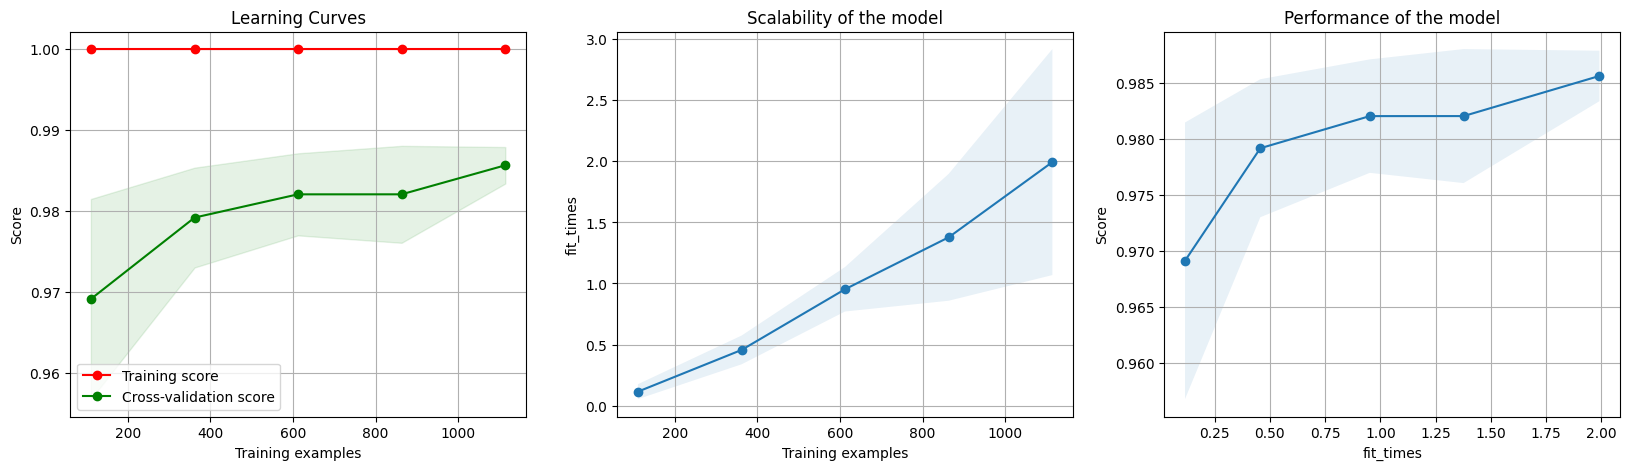

In [81]:
# plot learning curces
plot_learning_curve(grid_classifier_3.best_estimator_, 'Learning Curves',
                    X_train_combined, y_train, n_jobs=-1)

In [82]:
# let's check the train scores
print(grid_classifier_3.best_estimator_.score(X_train_combined, y_train))

# let's check the cross validation score
print(grid_classifier_3.best_score_)

1.0
0.987787356321839


In [83]:
# Final Pipeline
def final_pipeline(text):
    X_features, feature_names = featurizer.fit_transform(text)
    df_feature_test = pd.DataFrame(X_features, columns=feature_names)
    X_test_text = pd.DataFrame(text)
    df_feature_test['no_of_spelling_mistakes'] = X_test_text.iloc[:, 0].swifter.apply(lambda x: check_spelling(x))
    X_test_combined = pd.concat((pd.DataFrame(X_test_cleaned, columns=['cleaned text']),
                                 df_feature_test), axis=1)
    predictions = grid_classifier_3.best_estimator_.predict(X_test_combined)
    return predictions

In [84]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test_cleaned)

/content/drive/Othercomputers/Samsung_Laptop/PROGRAMMING/Python/Custom_Functions_py_files/custom_preprocessor_mod.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


Pandas Apply:   0%|          | 0/1950 [00:00<?, ?it/s]

In [85]:
print('\nTest set classification report:\n\n', classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1684
           1       0.98      0.89      0.93       266

    accuracy                           0.98      1950
   macro avg       0.98      0.94      0.96      1950
weighted avg       0.98      0.98      0.98      1950

